In [5]:
from functools import partial

import jax

from jax import config
config.update("jax_enable_x64", True)

import jax.numpy as np
import flax.linen as nn
import optax
import diffrax as dfx
import math
from tensorflow_probability.substrates import jax as tfp

from sklearn import datasets, preprocessing

import matplotlib.pyplot as plt
from tqdm import trange

## The Dataset

(-2.0, 2.0)

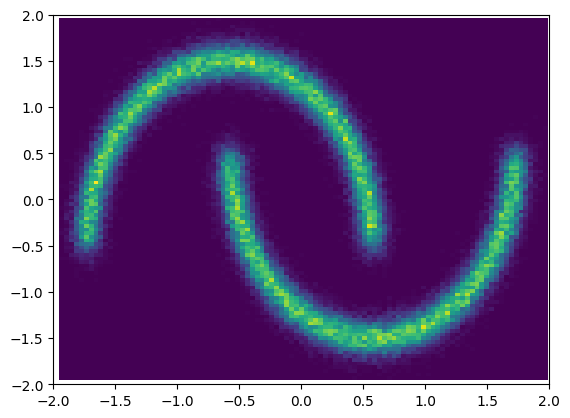

In [6]:
n_samples = 100_000

x, _ = datasets.make(n_samples=n_samples, noise=.06)

scaler = preprocessing.StandardScaler()
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)

## Implementation

In [10]:
class MLP(nn.Module):
    """ A simple MLP in Flax.
    """
    hidden_dim: int = 32
    out_dim: int = 2
    n_layers: int = 3

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x

In [59]:
class AffineBijector:
    def __init__(self, shift_and_log_scale):
        self.shift_and_log_scale = shift_and_log_scale

    def forward_and_log_det(self, x):
        shift, log_scale = np.split(self.shift_and_log_scale, 2, axis=-1)
        y = x * np.exp(log_scale) + shift
        log_det = log_scale
        return y, log_det

    def inverse_and_log_det(self, y):
        shift, log_scale = np.split(self.shift_and_log_scale, 2, axis=-1)
        x = (y - shift) * np.exp(-log_scale)
        log_det = -log_scale
        return x, log_det

class MaskedCoupling:
    def __init__(self, mask, conditioner, bijector):
        """Coupling layer with masking and conditioner."""
        self.mask = mask
        self.conditioner = conditioner
        self.bijector = bijector

    def forward_and_log_det(self, x):
        """Transforms masked indices of `x` conditioned on unmasked indices using bijector."""
        x_cond = np.where(self.mask, 0.0, x)
        bijector_params = self.conditioner(x_cond)
        y, log_det = self.bijector(bijector_params).forward_and_log_det(x)
        log_det = np.where(self.mask, log_det, 0.0)
        y = np.where(self.mask, y, x)
        return y, np.sum(log_det, axis=-1)

    def inverse_and_log_det(self, y):
        """Transforms masked indices of `y` conditioned on unmasked indices using bijector."""
        y_cond = np.where(self.mask, 0.0, y)
        bijector_params = self.conditioner(y_cond)
        x, log_det = self.bijector(bijector_params).inverse_and_log_det(y)
        log_det = np.where(self.mask, log_det, 0.0)
        x = np.where(self.mask, x, y)
        return x, np.sum(log_det, axis=-1)

In [102]:
class RealNVP(nn.Module):
    n_transforms: int = 4
    d_params: int = 2
    d_hidden: int = 128
    n_layers: int = 4

    def setup(self):
        self.mask_list = [np.arange(self.d_params) % 2 == i % 2 for i in range(self.n_transforms)]
        self.conditioner_list = [MLP(self.d_hidden, 2 * self.d_params, self.n_layers) for _ in range(self.n_transforms)]
        self.base_dist = tfp.distributions.Normal(loc=np.zeros(self.d_params), scale=np.ones(self.d_params))
    
    def log_prob(self, x):
        log_prob = np.zeros(x.shape[:-1])
        for mask, conditioner in zip(self.mask_list[::-1], self.conditioner_list[::-1]):
            x, ldj = MaskedCoupling(mask, conditioner, AffineBijector).inverse_and_log_det(x)
            log_prob += ldj
        return log_prob + self.base_dist.log_prob(x).sum(-1)

    def sample(self, sample_shape, key, n_transforms=None):
        x = self.base_dist.sample(key, sample_shape)
        for mask, conditioner in zip(self.mask_list[:n_transforms], self.conditioner_list[:n_transforms]):
            x, _ = MaskedCoupling(mask, conditioner, AffineBijector).forward_and_log_det(x)
        return x

    def __call__(self, x):
        return self.log_prob(x)

In [103]:
model = RealNVP()

key = jax.random.PRNGKey(0)
params = model.init(key, x[:2])

# Test log_prob
model.apply(params, x[:4])

Array([-3.35979128, -2.8513697 , -2.8622152 , -3.03087519], dtype=float64)

In [104]:
opt = optax.adam(learning_rate=1e-3)
opt_state = opt.init(params)

In [105]:
@jax.jit
def train_step(params, opt_state, x):
    def loss_fn(params):
        return -model.apply(params, x).mean()
    loss, grad = jax.value_and_grad(loss_fn)(params)
    updates, opt_state = opt.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

In [106]:
n_steps = 10_000
n_batch = 128

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]

        loss, params, opt_state = train_step(params, opt_state, x_batch)

        steps.set_postfix(val=loss)

100%|██████████| 10000/10000 [01:31<00:00, 108.79it/s, val=1.407515638835097]


Generate some samples.

In [107]:
n_samples = 100_000
x_sample = model.apply(params, key, (n_samples,), method=model.sample)

(-2.0, 2.0)

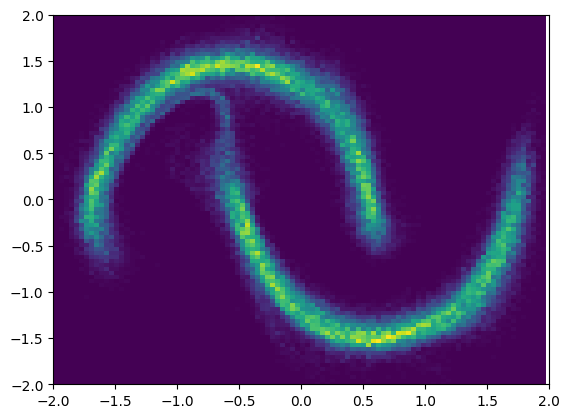

In [108]:

plt.hist2d(x_sample[:, 0], x_sample[:, 1], bins=100)
plt.xlim(-2 ,2)
plt.ylim(-2, 2)